# PyTorch

### Урок 2. CNN and LSTM for human action recognition

In [1]:
import sys
import numpy as np
import pandas as pd
import time
import math

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
print("Python : %s" % sys.version)
print("Pytorch: %s" % torch.__version__)

Python : 3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]
Pytorch: 1.6.0


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
class LSTM_net(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim,layer_num,batch_first=True)
#       self.dr = torch.nn.Dropout2d(0.25)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        
    def forward(self,inputs):
        x = inputs
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [5]:
class Test_Dataset(Dataset):
    def __init__(self):
        self.samples = list(range(0, 100)) ##генерируем случайные данные
        # Все подготовления данных происходят в инициализации:
        # - разделение данных на train/test/ validate
        # - аугментация (трансформация) данных 
        # - чтение аннотаций
        # - считывание по индексу

    def __len__(self):
        # # Возвращает данные и лейблы
        # - Применяет выбранные трансформации к данным
        # - отправление данных на GPU
        # - лучше возвращать данные как тензор или словарь
        return len(self.samples) # возвращаем данные

    def __getitem__(self, idx):
        return (self.samples[idx], label) 

In [6]:
class Skeleton_Dataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform

    def __len__(self):
        return len(self.data) 
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(45,75)
        label = self.data.iloc[idx,-1]
        if self.transform != None:
            item = self.transform(item)

        return (item, label)

In [7]:
skeletons = pd.read_csv("skels.csv")

In [8]:
skeletons.head()

,0,1,2,3,4,5,6,7,8,9,...,3366,3367,3368,3369,3370,3371,3372,3373,3374,labels
0,-0.526048,-0.277147,2.987706,-0.606184,-0.010056,3.010000,-0.681454,0.251614,3.020046,-0.708330,...,-0.619659,0.647852,2.708625,-0.598600,0.593635,2.707864,-0.601837,0.592191,2.697301,0
1,-0.325320,-0.560200,3.244968,-0.296753,-0.312155,3.234485,-0.267607,-0.066345,3.212031,-0.286594,...,-0.066076,-0.459657,3.206000,-0.227804,-0.654428,3.002556,-0.231687,-0.655208,3.000000,1
2,-0.134503,0.387048,3.797468,-0.135835,0.648782,3.669347,-0.137341,0.904024,3.529603,-0.131990,...,-0.332011,0.576840,3.451273,0.011452,0.521624,3.528420,-0.011325,0.589017,3.480000,1
3,0.371560,-0.187321,2.853457,0.388124,0.118966,2.756247,0.402399,0.418116,2.643035,0.354668,...,0.106246,0.619960,2.735462,0.352891,-0.375651,2.625237,0.465385,-0.316062,2.651301,2
4,-0.193082,-0.178566,2.814345,-0.196894,0.114788,2.849780,-0.198289,0.400548,2.872416,-0.178771,...,-0.567993,-0.426740,2.994171,0.102882,-0.492025,3.011537,0.063065,-0.435819,3.055625,3


In [9]:
LABELS = {0: "cheer up", 1: "jump up", 2:  "hand waving", 3: "sitting down", 4: "clapping"}

In [10]:
dataset = Skeleton_Dataset(file_path = "skels.csv", transform=None)
skel, lab = dataset.__getitem__(41)

In [11]:
skel.shape

(45, 75)

In [12]:
LABELS[lab]

'sitting down'

In [13]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.75*len(dataset)),int(0.25*len(dataset))])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size = 16, shuffle=True)

In [14]:
n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 2
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)

In [15]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return LABELS[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m:02.0f}m {s:02.0f}s'

In [16]:
sket_tensor = torch.from_numpy(skel).unsqueeze(0).float()
sket_tensor.size()

torch.Size([1, 45, 75])

In [17]:
output = rnn(sket_tensor.to(device))
output.topk(5)

torch.return_types.topk(
values=tensor([[ 0.0832, -0.0674, -0.0763, -0.0847, -0.1435]], device='cuda:0',
       grad_fn=<TopkBackward>),
indices=tensor([[2, 3, 1, 0, 4]], device='cuda:0'))

<IPython.core.display.Javascript object>


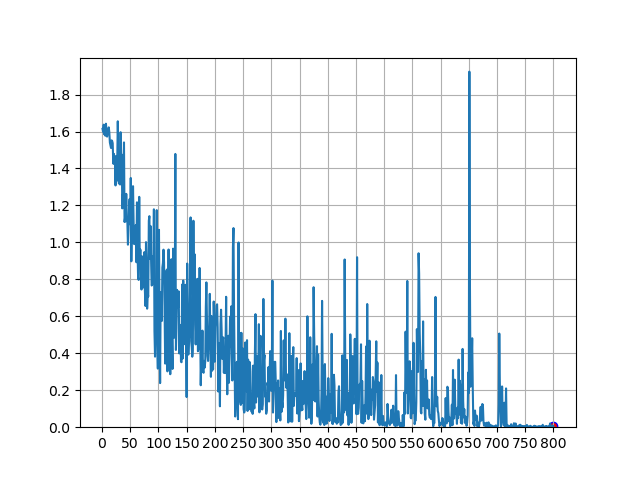

Epoch :   0 iter :  0 (00m 00s) 1.616556 | hand waving ✓
Epoch :  16 iter : 20 (00m 52s) 1.576304 | sitting down ✗ (hand waving)
Epoch :  33 iter : 10 (01m 44s) 1.470772 | sitting down ✗ (jump up)
Epoch :  50 iter :  0 (02m 34s) 1.147563 | cheer up ✗ (hand waving)
Epoch :  66 iter : 20 (03m 25s) 1.147193 | clapping ✗ (hand waving)
Epoch :  83 iter : 10 (04m 16s) 0.946212 | clapping ✗ (hand waving)
Epoch : 100 iter :  0 (05m 07s) 0.695833 | clapping ✗ (hand waving)
Epoch : 116 iter : 20 (05m 57s) 0.879865 | clapping ✗ (jump up)
Epoch : 133 iter : 10 (06m 48s) 1.056197 | jump up ✓
Epoch : 150 iter :  0 (07m 39s) 0.444495 | clapping ✓
Epoch : 166 iter : 20 (08m 29s) 0.691040 | cheer up ✗ (hand waving)
Epoch : 183 iter : 10 (09m 20s) 0.284012 | clapping ✓
Epoch : 200 iter :  0 (10m 11s) 0.607630 | sitting down ✓
Epoch : 216 iter : 20 (11m 01s) 0.628550 | hand waving ✓
Epoch : 233 iter : 10 (11m 52s) 0.345454 | jump up ✓
Epoch : 250 iter :  0 (12m 43s) 0.418291 | sitting down ✓
Epoch : 266 

In [19]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(), lr=learning_rate, momentum=0.9)

all_losses = []
start = time.time()
counter = 0

EPOCHS = 800
xlist = np.arange(1,EPOCHS+1)
ylist = [0 for _ in np.arange(1,EPOCHS+1)]
fig = plt.figure()
ax = fig.add_subplot(111)

plt.ion()

for epoch in range(EPOCHS):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 

        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        ##### Cделать обновление графика loss по ходу обучению
        ax.clear()
        ylist[epoch] = loss.item()
        ax.set_ylim(0, 2)
        ax.set_yticks(np.arange(0, 2, 0.2))
        ax.set_xticks(np.arange(0, EPOCHS+1, 50))
        ax.grid(True)
        ax.plot(xlist, ylist)
        ax.scatter(epoch+1, loss.item(), marker='o', c='r', edgecolor='b')
        fig.canvas.draw()        

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            
            ##### Cделать более аккуратный вывод для каждой эпохи
            print(f'Epoch : {epoch:3d} iter : {i:2d} ({timeSince(start)}) {loss:.6f} | {guess} {correct}')
        
        counter = counter + 1

    if counter % 100 == 0:
        all_losses.append(current_loss / 25)
        current_loss = 0
        
plt.ioff()